In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Download Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d /content/drive/MyDrive/Text\ mining/

--2024-06-08 17:21:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-08 17:21:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-08 17:21:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout, Input, GRU
from keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
import matplotlib.pyplot as plt


train_df = pd.read_csv('/content/drive/MyDrive/Text mining/train_cleaned_stemming.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Text mining/test_cleaned_stemming.csv')
train_reviews = pd.read_csv('/content/drive/MyDrive/Text mining/train_reviews_cleaned.csv')
test_reviews = pd.read_csv('/content/drive/MyDrive/Text mining/test_reviews_cleaned.csv')

train_df = pd.merge(train_df, train_reviews, left_on='Index', right_on='Index', how='left')
test_df = pd.merge(test_df, test_reviews, left_on='Index', right_on='Index', how='left')

train_df['description'].fillna('', inplace=True)
test_df['description'].fillna('', inplace=True)
train_df['host_about'].fillna('', inplace=True)
test_df['host_about'].fillna('', inplace=True)
train_df['comments'].fillna('', inplace=True)
test_df['comments'].fillna('', inplace=True)

train_texts = train_df['description'] + ' ' + train_df['host_about'] + ' ' + train_df['comments']
test_texts = test_df['description'] + ' ' + test_df['host_about'] + ' ' + test_df['comments']

label_column = 'unlisted'
y_train = train_df[label_column]

X_train, X_val, y_train, y_val = train_test_split(train_texts, y_train, test_size=0.2, random_state=42)

print(train_df.head())

   Index                                        description  \
0   5271  share mix room hostel share bathroom locat rig...   
1   5271  share mix room hostel share bathroom locat rig...   
2   5271  share mix room hostel share bathroom locat rig...   
3   5271  share mix room hostel share bathroom locat rig...   
4   5271  share mix room hostel share bathroom locat rig...   

           host_about  unlisted  \
0  aloj local registr         0   
1  aloj local registr         0   
2  aloj local registr         0   
3  aloj local registr         0   
4  aloj local registr         0   

                                            comments  
0  cozy comfortable house stay in never worry saf...  
1                                               good  
2  first hostel experience say pretty hard beat p...  
3  kostet neu deshalb funktionierte tadellos schn...  
4  fine dorm think people staying far less bathro...  


## Logistic Regression

      Metric     Train  Validation
0   Accuracy  0.780648    0.784569
1   F1-Score  0.316292    0.322628
2  Precision  0.199783    0.204638
3     Recall  0.758813    0.761960


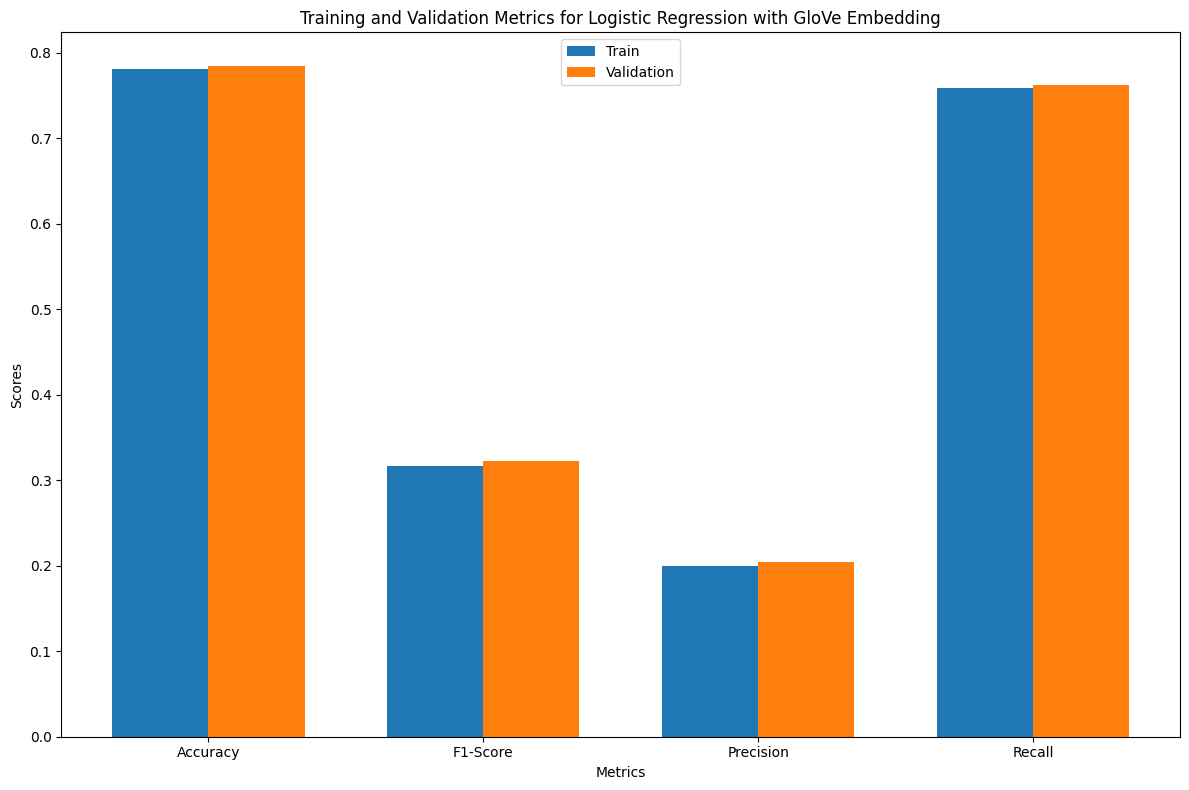

In [ ]:
embedding_index = {}
glove_file_path = '/content/drive/MyDrive/Text mining/glove.6B.100d.txt'
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=500)
X_val_seq = pad_sequences(X_val_seq, maxlen=500)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

def get_avg_embedding(text_sequences, embedding_matrix):
    avg_embeddings = []
    for seq in text_sequences:
        valid_embeddings = [embedding_matrix[idx] for idx in seq if idx != 0]
        if valid_embeddings:
            avg_embedding = np.mean(valid_embeddings, axis=0)
        else:
            avg_embedding = np.zeros(100)
        avg_embeddings.append(avg_embedding)
    return np.array(avg_embeddings)

X_train_emb = get_avg_embedding(X_train_seq, embedding_matrix)
X_val_emb = get_avg_embedding(X_val_seq, embedding_matrix)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model = LogisticRegression(class_weight=class_weights, max_iter=1000)
model.fit(X_train_emb, y_train)

y_train_pred = model.predict(X_train_emb)
y_val_pred = model.predict(X_val_emb)

train_metrics = {
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred, zero_division=1),
    'Precision': precision_score(y_train, y_train_pred, zero_division=1),
    'Recall': recall_score(y_train, y_train_pred)
}

val_metrics = {
    'Accuracy': accuracy_score(y_val, y_val_pred),
    'F1-Score': f1_score(y_val, y_val_pred, zero_division=1),
    'Precision': precision_score(y_val, y_val_pred, zero_division=1),
    'Recall': recall_score(y_val, y_val_pred)
}

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': train_metrics.values(),
    'Validation': val_metrics.values()
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for Logistic Regression with GloVe Embedding')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


      Metric     Train  Validation
0   Accuracy  0.963425    0.956003
1   F1-Score  0.781967    0.735350
2  Precision  0.650117    0.617951
3     Recall  0.980905    0.907818


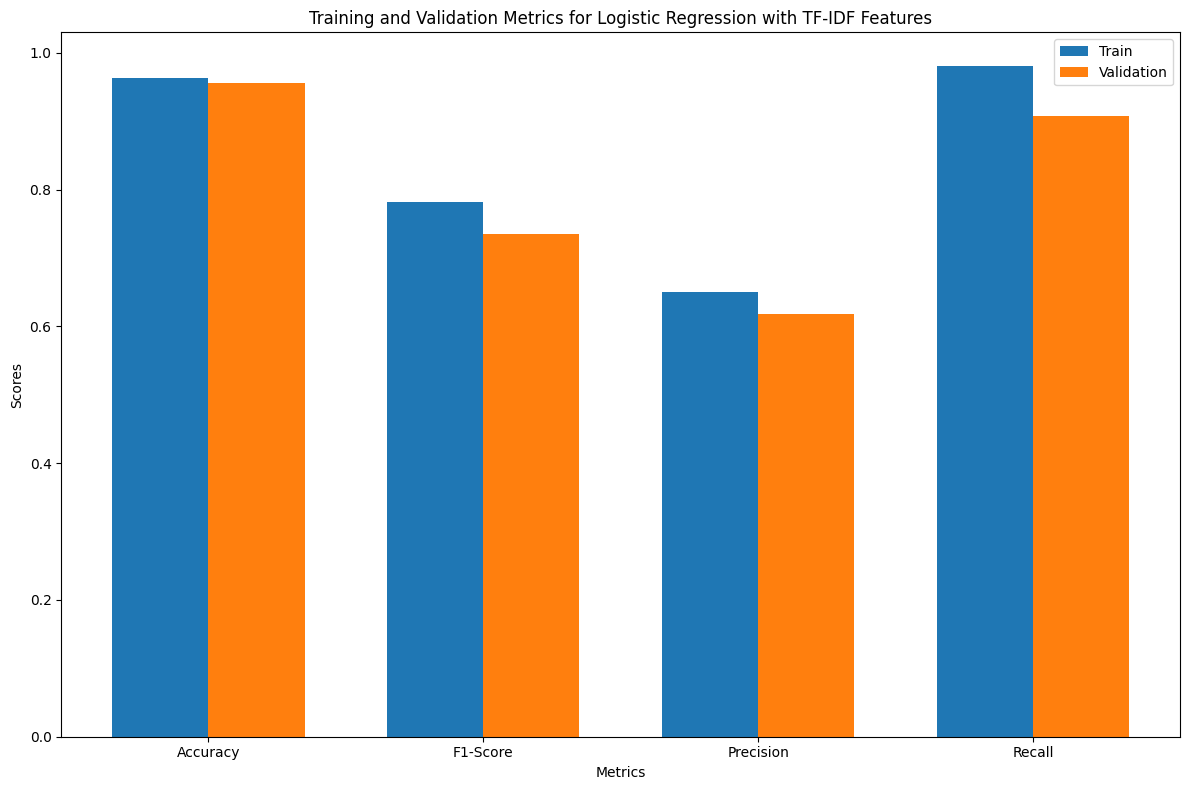

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model = LogisticRegression(class_weight=class_weights, max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_train_pred = model.predict(X_train_tfidf)
y_val_pred = model.predict(X_val_tfidf)

train_metrics = {
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred, zero_division=1),
    'Precision': precision_score(y_train, y_train_pred, zero_division=1),
    'Recall': recall_score(y_train, y_train_pred)
}

val_metrics = {
    'Accuracy': accuracy_score(y_val, y_val_pred),
    'F1-Score': f1_score(y_val, y_val_pred, zero_division=1),
    'Precision': precision_score(y_val, y_val_pred, zero_division=1),
    'Recall': recall_score(y_val, y_val_pred)
}

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': train_metrics.values(),
    'Validation': val_metrics.values()
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for Logistic Regression with TF-IDF Features')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

      Metric     Train  Validation
0   Accuracy  0.695160    0.693154
1   F1-Score  0.179340    0.175489
2  Precision  0.102446    0.099987
3     Recall  0.719019    0.716616


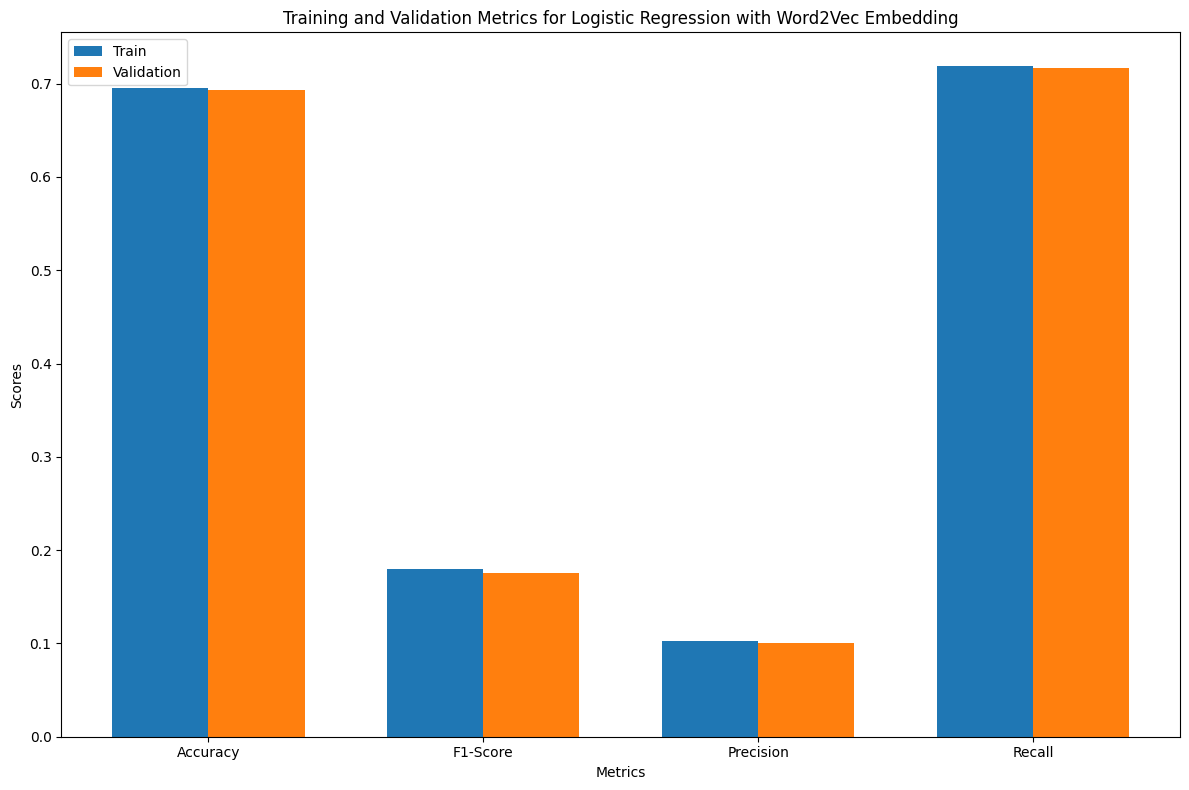

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=128)
X_val_seq = pad_sequences(X_val_seq, maxlen=128)

sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

def get_avg_embedding(text_sequences, embedding_matrix):
    avg_embeddings = []
    for seq in text_sequences:
        valid_embeddings = [embedding_matrix[idx] for idx in seq if idx != 0]
        if valid_embeddings:
            avg_embedding = np.mean(valid_embeddings, axis=0)
        else:
            avg_embedding = np.zeros(100)
        avg_embeddings.append(avg_embedding)
    return np.array(avg_embeddings)

X_train_emb = get_avg_embedding(X_train_seq, embedding_matrix)
X_val_emb = get_avg_embedding(X_val_seq, embedding_matrix)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model = LogisticRegression(class_weight=class_weights, max_iter=1000)
model.fit(X_train_emb, y_train)

y_train_pred = model.predict(X_train_emb)
y_val_pred = model.predict(X_val_emb)

train_metrics = {
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred, zero_division=1),
    'Precision': precision_score(y_train, y_train_pred, zero_division=1),
    'Recall': recall_score(y_train, y_train_pred)
}

val_metrics = {
    'Accuracy': accuracy_score(y_val, y_val_pred),
    'F1-Score': f1_score(y_val, y_val_pred, zero_division=1),
    'Precision': precision_score(y_val, y_val_pred, zero_division=1),
    'Recall': recall_score(y_val, y_val_pred)
}

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': train_metrics.values(),
    'Validation': val_metrics.values()
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for Logistic Regression with Word2Vec Embedding')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


## LSTM

Epoch 1/5
4540/4540 [==============================] - 88s 19ms/step - loss: 0.2071 - accuracy: 0.9326 - val_loss: 0.1042 - val_accuracy: 0.9614
Epoch 2/5
4540/4540 [==============================] - 86s 19ms/step - loss: 0.1183 - accuracy: 0.9552 - val_loss: 0.0693 - val_accuracy: 0.9744
Epoch 3/5
4540/4540 [==============================] - 89s 20ms/step - loss: 0.0945 - accuracy: 0.9638 - val_loss: 0.0588 - val_accuracy: 0.9804
Epoch 4/5
4540/4540 [==============================] - 89s 20ms/step - loss: 0.0728 - accuracy: 0.9734 - val_loss: 0.0436 - val_accuracy: 0.9854
Epoch 5/5
2270/2270 [==============================] - 11s 5ms/step
      Metric     Train  Validation
0   Accuracy  0.989300    0.986743
1   F1-Score  0.895626    0.868497
2  Precision  0.816990    0.792425
3     Recall  0.991010    0.960725


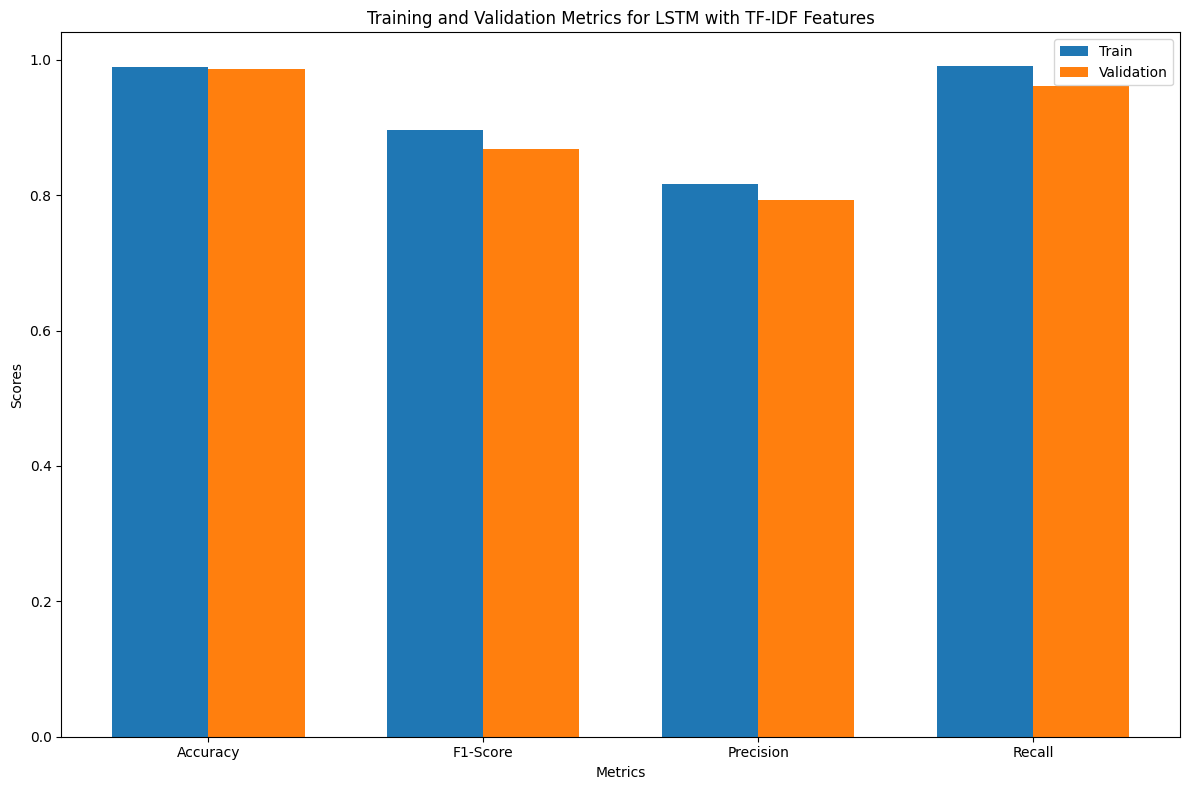

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

X_train_tfidf = X_train_tfidf.toarray()
X_val_tfidf = X_val_tfidf.toarray()

X_train_tfidf = X_train_tfidf.reshape((X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1]))
X_val_tfidf = X_val_tfidf.reshape((X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1]))

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(LSTM(100, input_shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_data=(X_val_tfidf, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_tfidf) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_tfidf) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': train_metrics.values(),
    'Validation': val_metrics.values()
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for LSTM with TF-IDF Features')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


Epoch 1/5
4540/4540 [==============================] - 436s 95ms/step - loss: 0.4823 - accuracy: 0.8031 - val_loss: 0.1827 - val_accuracy: 0.9483
Epoch 2/5
4540/4540 [==============================] - 430s 95ms/step - loss: 0.2275 - accuracy: 0.9221 - val_loss: 0.1161 - val_accuracy: 0.9612
Epoch 3/5
4540/4540 [==============================] - 428s 94ms/step - loss: 0.1612 - accuracy: 0.9412 - val_loss: 0.1060 - val_accuracy: 0.9553
Epoch 4/5
4540/4540 [==============================] - 430s 95ms/step - loss: 0.1345 - accuracy: 0.9465 - val_loss: 0.1136 - val_accuracy: 0.9519
Epoch 5/5
2270/2270 [==============================] - 41s 18ms/step
      Metric     Train  Validation
0   Accuracy  0.956590    0.956112
1   F1-Score  0.676615    0.667362
2  Precision  0.516580    0.509723
3     Recall  0.980312    0.966163


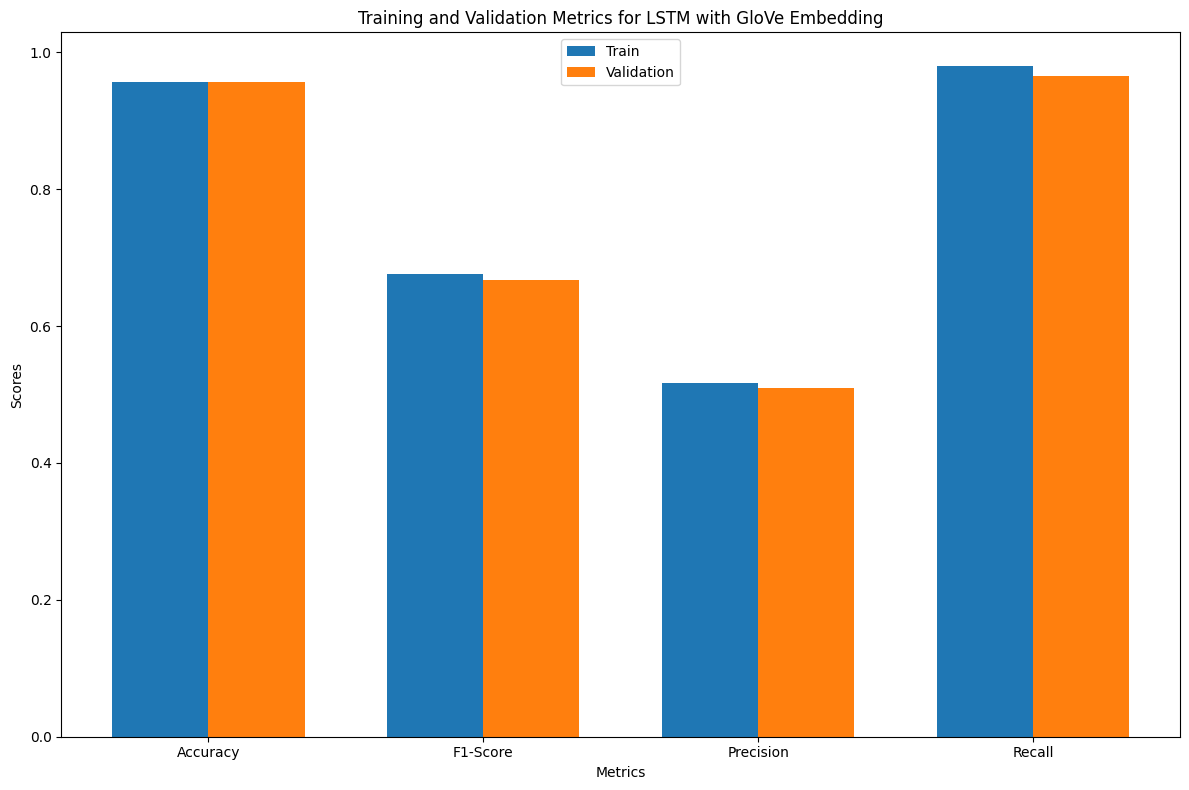

In [ ]:
embedding_index = {}
glove_file_path = '/content/drive/MyDrive/Text mining/glove.6B.100d.txt'
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=128)
X_val_seq = pad_sequences(X_val_seq, maxlen=128)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=128, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_data=(X_val_seq, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_seq) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_seq) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': list(train_metrics.values()),
    'Validation': list(val_metrics.values())
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for LSTM with GloVe Embedding')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

Epoch 1/5
4540/4540 [==============================] - 450s 99ms/step - loss: 0.4509 - accuracy: 0.8023 - val_loss: 0.2272 - val_accuracy: 0.9217
Epoch 2/5
4540/4540 [==============================] - 425s 94ms/step - loss: 0.2445 - accuracy: 0.9076 - val_loss: 0.1793 - val_accuracy: 0.9312
Epoch 3/5
4540/4540 [==============================] - 418s 92ms/step - loss: 0.2122 - accuracy: 0.9128 - val_loss: 0.1765 - val_accuracy: 0.9338
Epoch 4/5
4540/4540 [==============================] - 416s 92ms/step - loss: 0.1875 - accuracy: 0.9254 - val_loss: 0.1877 - val_accuracy: 0.9228
Epoch 5/5
2270/2270 [==============================] - 38s 17ms/step
      Metric     Train  Validation
0   Accuracy  0.929280    0.929335
1   F1-Score  0.559774    0.554156
2  Precision  0.393304    0.388882
3     Recall  0.970579    0.963746


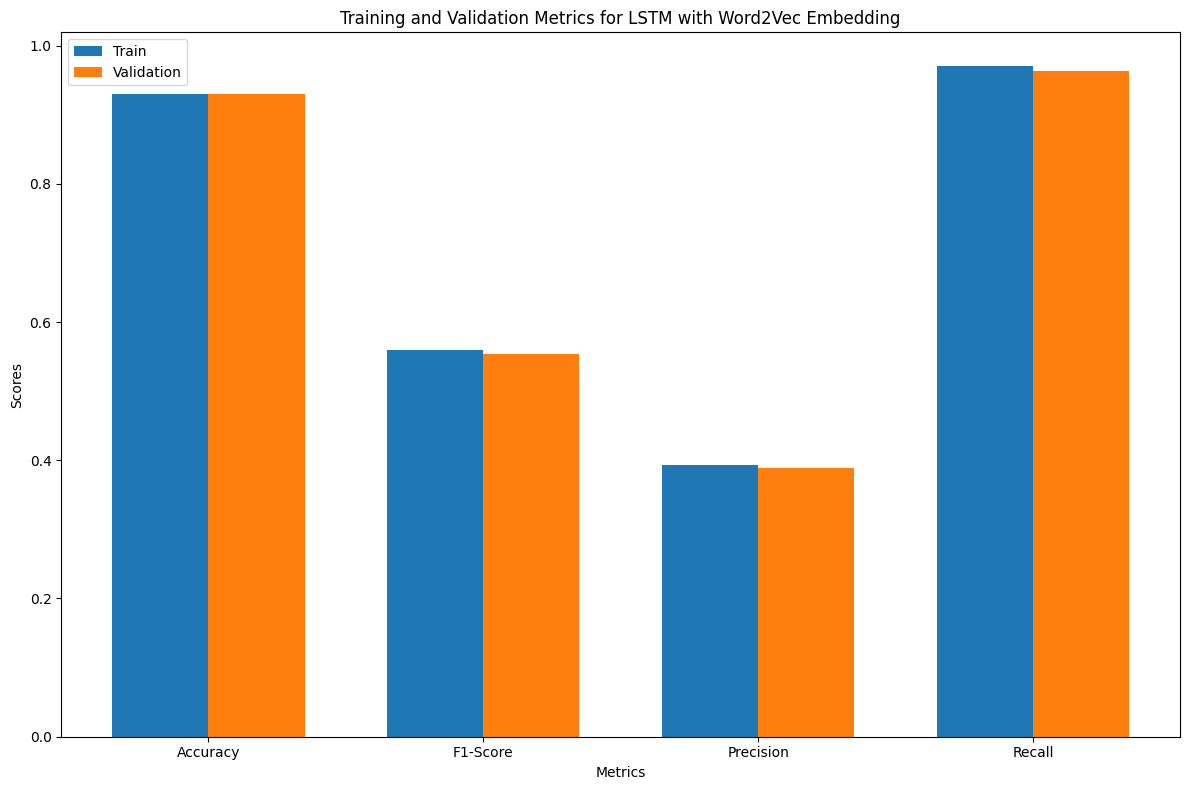

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=128)
X_val_seq = pad_sequences(X_val_seq, maxlen=128)

sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=128, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_data=(X_val_seq, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_seq) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_seq) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': list(train_metrics.values()),
    'Validation': list(val_metrics.values())
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for LSTM with Word2Vec Embedding')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

## MLP

Epoch 1/5
2270/2270 [==============================] - 19s 8ms/step - loss: 0.1620 - accuracy: 0.9627 - val_loss: 0.0682 - val_accuracy: 0.9850
Epoch 2/5
2270/2270 [==============================] - 17s 8ms/step - loss: 0.0502 - accuracy: 0.9904 - val_loss: 0.0371 - val_accuracy: 0.9923
Epoch 3/5
2270/2270 [==============================] - 17s 8ms/step - loss: 0.0294 - accuracy: 0.9941 - val_loss: 0.0266 - val_accuracy: 0.9942
Epoch 4/5
2270/2270 [==============================] - 17s 8ms/step - loss: 0.0235 - accuracy: 0.9955 - val_loss: 0.0253 - val_accuracy: 0.9941
Epoch 5/5
2270/2270 [==============================] - 4s 2ms/step
      Metric     Train  Validation
0   Accuracy  0.997020    0.994204
1   F1-Score  0.968802    0.937713
2  Precision  0.940411    0.918817
3     Recall  0.998960    0.957402


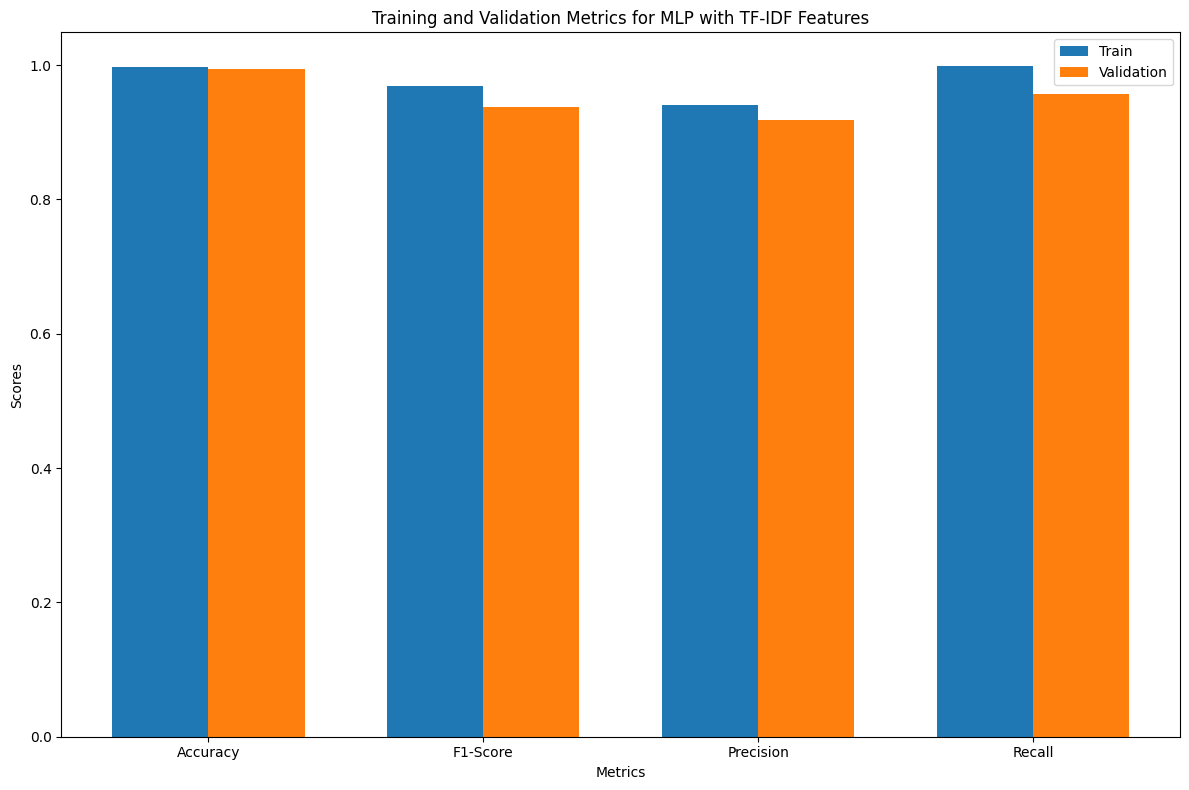

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = vectorizer.transform(X_val).toarray()

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X_train_tfidf.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_tfidf, y_train, epochs=5, batch_size=128, validation_data=(X_val_tfidf, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_tfidf) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_tfidf) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': list(train_metrics.values()),
    'Validation': list(val_metrics.values())
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for MLP with TF-IDF Features')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()




Epoch 1/5
2270/2270 [==============================] - 41s 18ms/step - loss: 0.4369 - accuracy: 0.9564 - val_loss: 0.3043 - val_accuracy: 0.9698
Epoch 2/5
2270/2270 [==============================] - 39s 17ms/step - loss: 0.4235 - accuracy: 0.9605 - val_loss: 0.3106 - val_accuracy: 0.9728
Epoch 3/5
2270/2270 [==============================] - 39s 17ms/step - loss: 0.4075 - accuracy: 0.9641 - val_loss: 0.3073 - val_accuracy: 0.9726
Epoch 4/5
2270/2270 [==============================] - 40s 17ms/step - loss: 0.3969 - accuracy: 0.9664 - val_loss: 0.3015 - val_accuracy: 0.9722
Epoch 5/5
2270/2270 [==============================] - 8s 4ms/step
      Metric     Train  Validation
0   Accuracy  0.985917    0.974711
1   F1-Score  0.837658    0.678565
2  Precision  0.898774    0.806237
3     Recall  0.784324    0.585801


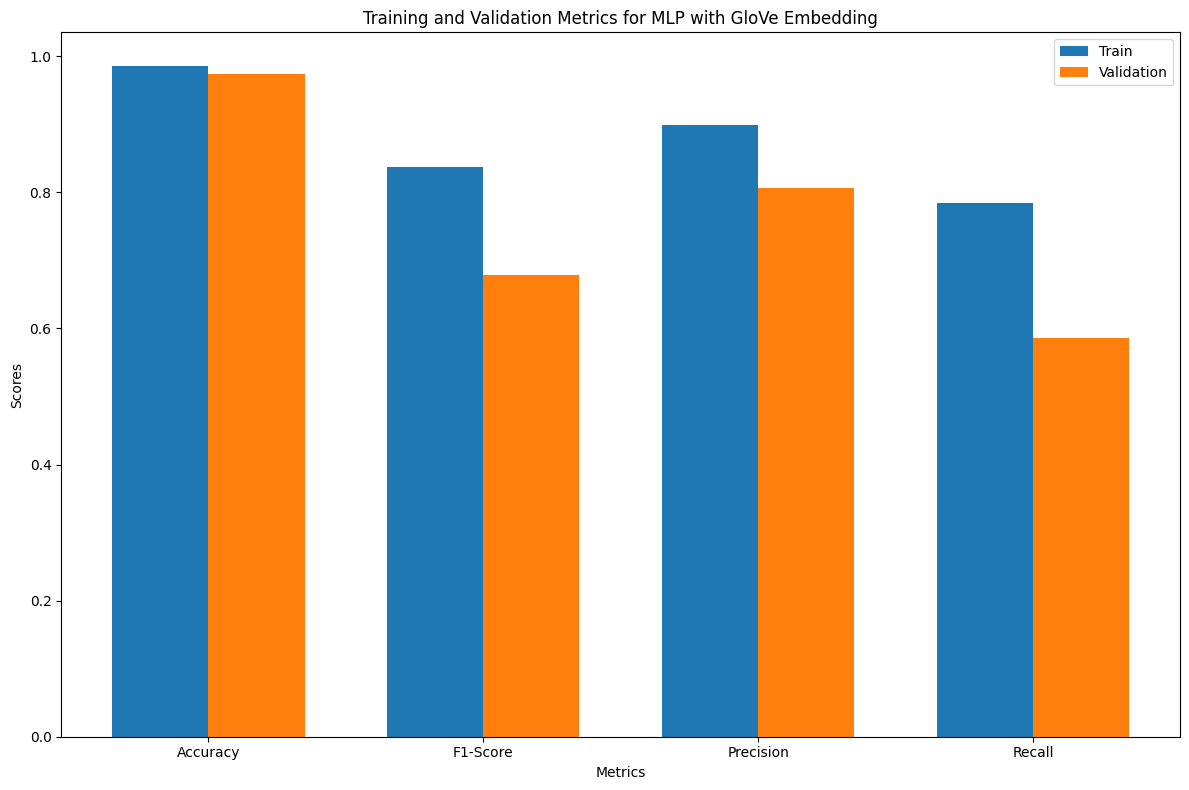

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=100)
X_val_seq = pad_sequences(X_val_seq, maxlen=100)

word_index = tokenizer.word_index

embedding_index = {}
glove_file_path = '/content/drive/MyDrive/Text mining/glove.6B.100d.txt'
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=128, validation_data=(X_val_seq, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_seq) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_seq) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': list(train_metrics.values()),
    'Validation': list(val_metrics.values())
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for MLP with GloVe Embedding')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()



Epoch 1/5
2270/2270 [==============================] - 41s 18ms/step - loss: 0.3116 - accuracy: 0.9231 - val_loss: 0.1797 - val_accuracy: 0.9716
Epoch 2/5
2270/2270 [==============================] - 41s 18ms/step - loss: 0.2657 - accuracy: 0.9440 - val_loss: 0.1646 - val_accuracy: 0.9748
Epoch 3/5
2270/2270 [==============================] - 41s 18ms/step - loss: 0.2412 - accuracy: 0.9531 - val_loss: 0.1455 - val_accuracy: 0.9756
Epoch 4/5
2270/2270 [==============================] - 41s 18ms/step - loss: 0.2193 - accuracy: 0.9574 - val_loss: 0.1266 - val_accuracy: 0.9764
Epoch 5/5
2270/2270 [==============================] - 8s 4ms/step
      Metric     Train  Validation
0   Accuracy  0.990229    0.976115
1   F1-Score  0.901042    0.734263
2  Precision  0.848710    0.744641
3     Recall  0.960253    0.724169


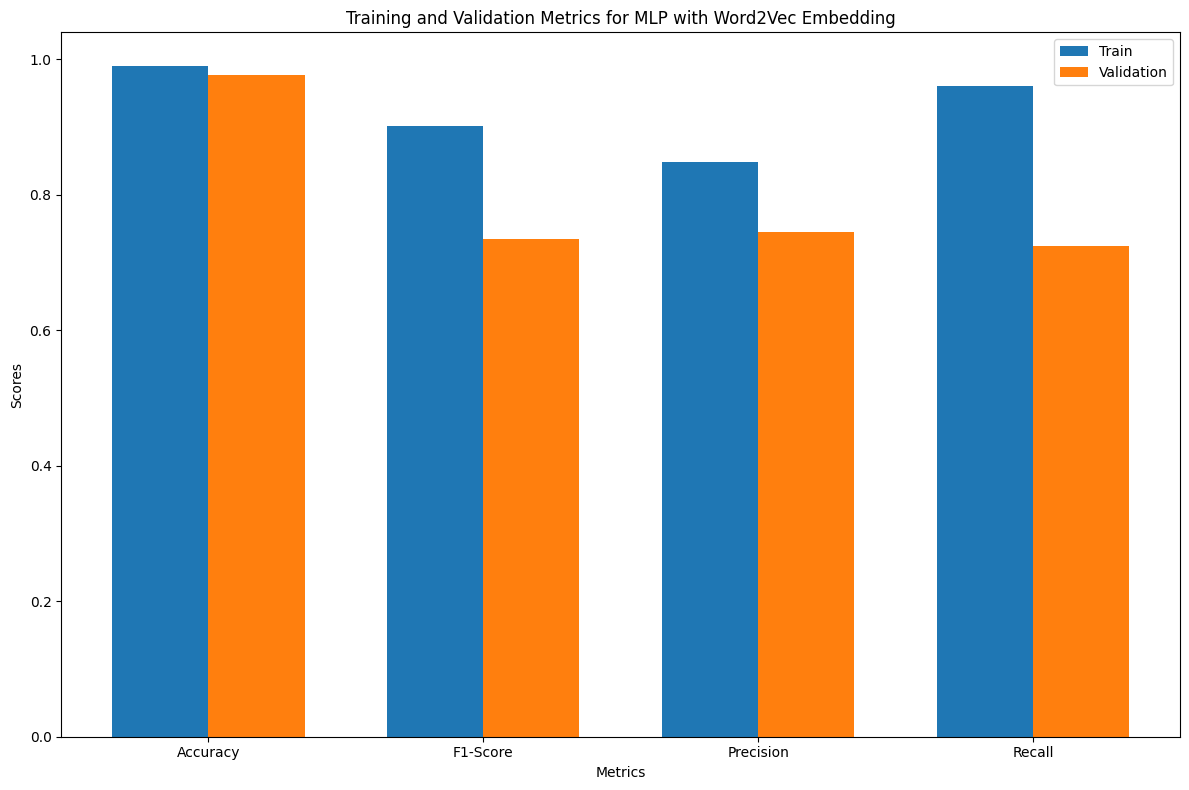

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=100)
X_val_seq = pad_sequences(X_val_seq, maxlen=100)

word_index = tokenizer.word_index

sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=128, validation_data=(X_val_seq, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_seq) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_seq) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': list(train_metrics.values()),
    'Validation': list(val_metrics.values())
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for MLP with Word2Vec Embedding')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()



## GRU

Epoch 1/5
4540/4540 [==============================] - 37s 7ms/step - loss: 0.2014 - accuracy: 0.9322 - val_loss: 0.1065 - val_accuracy: 0.9614
Epoch 2/5
4540/4540 [==============================] - 29s 6ms/step - loss: 0.1144 - accuracy: 0.9558 - val_loss: 0.0823 - val_accuracy: 0.9690
Epoch 3/5
4540/4540 [==============================] - 29s 6ms/step - loss: 0.0932 - accuracy: 0.9638 - val_loss: 0.0701 - val_accuracy: 0.9756
Epoch 4/5
4540/4540 [==============================] - 29s 6ms/step - loss: 0.0747 - accuracy: 0.9723 - val_loss: 0.0541 - val_accuracy: 0.9821
Epoch 5/5
2270/2270 [==============================] - 5s 2ms/step
      Metric     Train  Validation
0   Accuracy  0.988925    0.986247
1   F1-Score  0.892136    0.863729
2  Precision  0.812752    0.787366
3     Recall  0.988707    0.956495


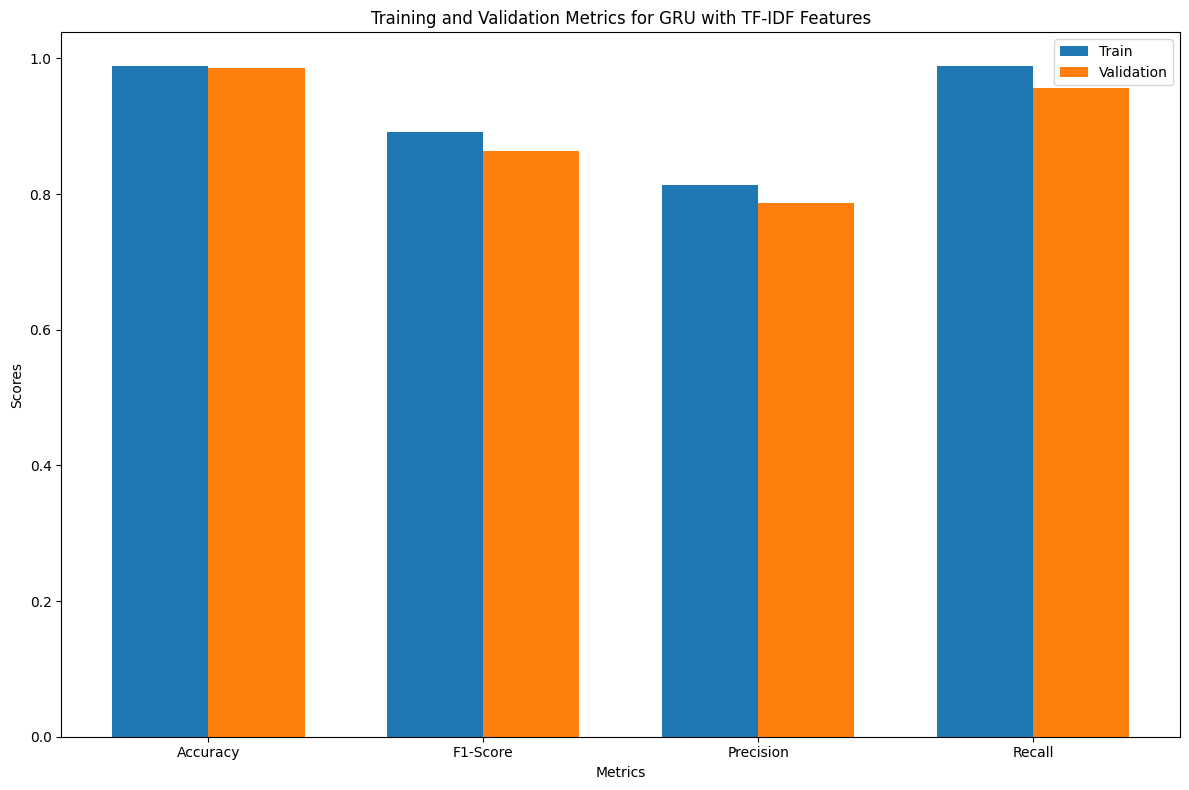

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

X_train_tfidf = X_train_tfidf.toarray()
X_val_tfidf = X_val_tfidf.toarray()

X_train_tfidf = X_train_tfidf.reshape((X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1]))
X_val_tfidf = X_val_tfidf.reshape((X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1]))

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(GRU(100, input_shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_data=(X_val_tfidf, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_tfidf) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_tfidf) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': list(train_metrics.values()),
    'Validation': list(val_metrics.values())
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for GRU with TF-IDF Features')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


Epoch 1/5
4540/4540 [==============================] - 532s 117ms/step - loss: 0.5050 - accuracy: 0.7311 - val_loss: 0.2103 - val_accuracy: 0.9257
Epoch 2/5
4540/4540 [==============================] - 529s 117ms/step - loss: 0.2033 - accuracy: 0.9288 - val_loss: 0.0829 - val_accuracy: 0.9711
Epoch 3/5
4540/4540 [==============================] - 533s 117ms/step - loss: 0.1511 - accuracy: 0.9436 - val_loss: 0.0900 - val_accuracy: 0.9694
Epoch 4/5
4540/4540 [==============================] - 530s 117ms/step - loss: 0.1314 - accuracy: 0.9476 - val_loss: 0.0893 - val_accuracy: 0.9604
Epoch 5/5
2270/2270 [==============================] - 48s 21ms/step
      Metric     Train  Validation
0   Accuracy  0.970515    0.971131
1   F1-Score  0.744276    0.743674
2  Precision  0.622075    0.624512
3     Recall  0.926226    0.919033


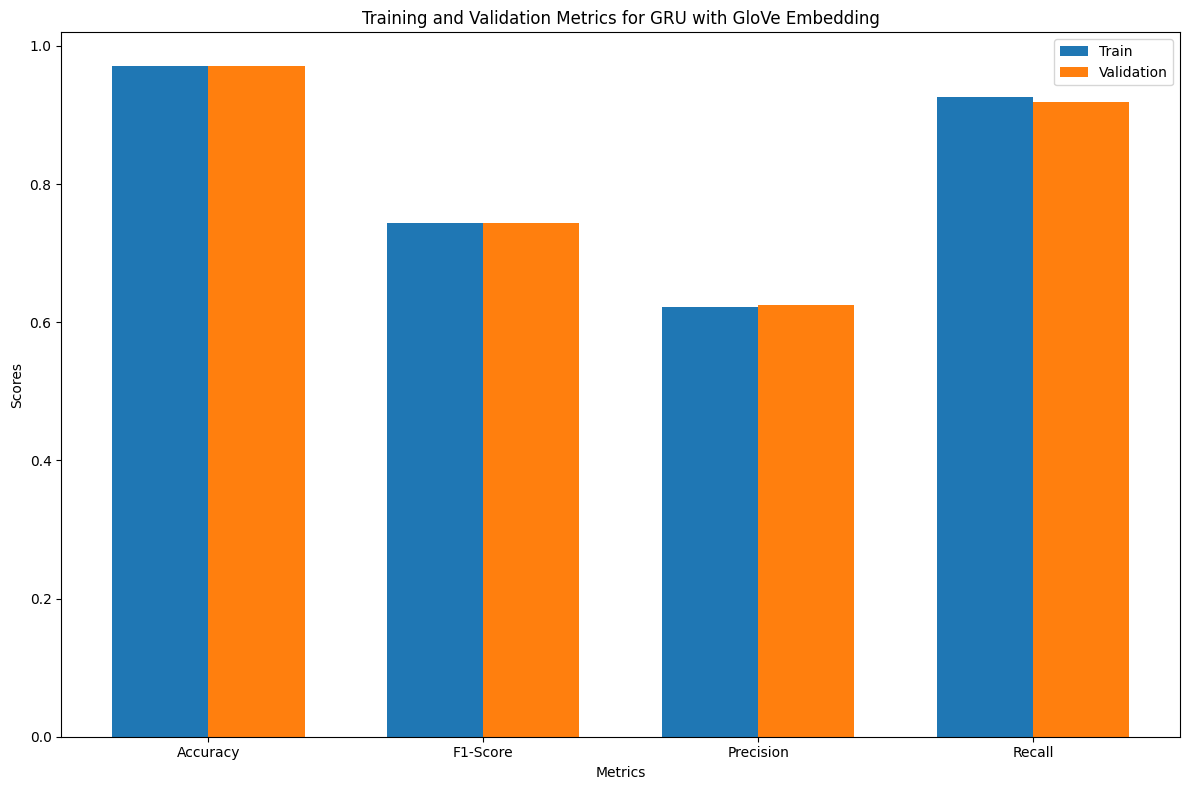

In [ ]:
embedding_index = {}
glove_file_path = '/content/drive/MyDrive/Text mining/glove.6B.100d.txt'
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=128)
X_val_seq = pad_sequences(X_val_seq, maxlen=128)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=128, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_data=(X_val_seq, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_seq) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_seq) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': list(train_metrics.values()),
    'Validation': list(val_metrics.values())
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for GRU with GloVe Embedding')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


Epoch 1/5
4540/4540 [==============================] - 550s 120ms/step - loss: 0.5165 - accuracy: 0.7306 - val_loss: 0.2850 - val_accuracy: 0.8914
Epoch 2/5
4540/4540 [==============================] - 557s 123ms/step - loss: 0.2637 - accuracy: 0.8930 - val_loss: 0.2020 - val_accuracy: 0.9254
Epoch 3/5
4540/4540 [==============================] - 521s 115ms/step - loss: 0.2188 - accuracy: 0.9103 - val_loss: 0.1950 - val_accuracy: 0.9176
Epoch 4/5
4540/4540 [==============================] - 517s 114ms/step - loss: 0.2093 - accuracy: 0.9136 - val_loss: 0.1632 - val_accuracy: 0.9370
Epoch 5/5
2270/2270 [==============================] - 46s 20ms/step
      Metric     Train  Validation
0   Accuracy  0.946437    0.947659
1   F1-Score  0.624961    0.626082
2  Precision  0.462496    0.464129
3     Recall  0.963373    0.961631


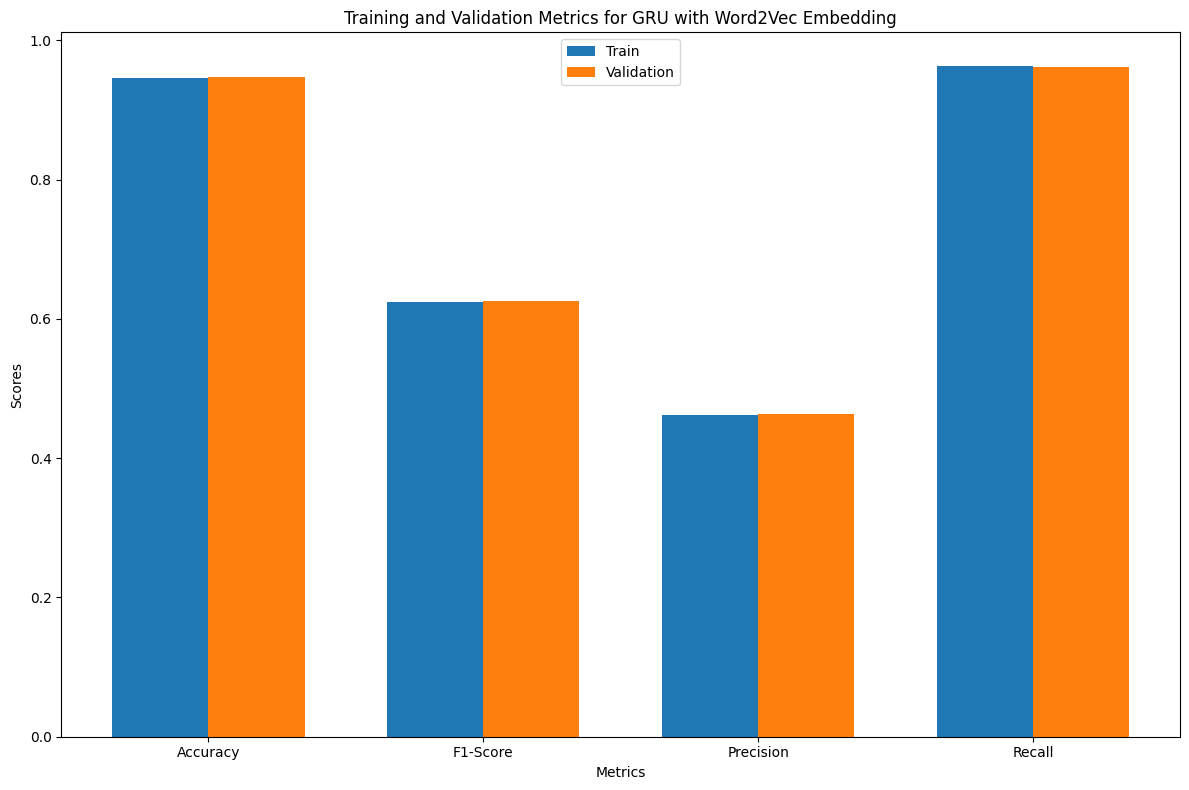

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_seq = pad_sequences(X_train_seq, maxlen=128)
X_val_seq = pad_sequences(X_val_seq, maxlen=128)

sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, zero_division=1),
        'Precision': precision_score(y_true, y_pred, zero_division=1),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=128, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_data=(X_val_seq, y_val), class_weight=class_weights, callbacks=[early_stopping])

y_train_pred = (model.predict(X_train_seq) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val_seq) > 0.5).astype("int32")

train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
results_df = pd.DataFrame({
    'Metric': metrics,
    'Train': list(train_metrics.values()),
    'Validation': list(val_metrics.values())
})

print(results_df)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width/2, results_df['Train'], width, label='Train')
ax.bar(x + width/2, results_df['Validation'], width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Validation Metrics for GRU with Word2Vec Embedding')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


## Test

In [ ]:
# Preprocess the test data using the same vectorizer
X_test = test_texts
X_test_tfidf = vectorizer.transform(X_test)

X_test_tfidf = X_test_tfidf.toarray()
X_test_tfidf = X_test_tfidf.reshape((X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1]))

# Predict on the test data
y_test_pred = (model.predict(X_test_tfidf) > 0.5).astype("int32")

# Add the 'Unlisted' column to the test_df
test_df1=test_df
test_df1['Unlisted'] = y_test_pred
test_df1.to_csv('/content/drive/MyDrive/Deep Learning Class/Group_11.csv', index=False)

1316/1316 [==============================] - 6s 5ms/step


In [ ]:
grouped = test_df1.groupby('Index')['Unlisted'].agg(['sum', 'count'])
grouped['Unlisted'] = (grouped['sum'] > (grouped['count'] / 2)).astype(int)

# Reset index to get the final dataframe with 'Index' and 'Unlisted' columns
final_df = grouped[['Unlisted']].reset_index()

# Save the final dataframe to a CSV file
final_df.to_csv('/content/drive/MyDrive/Deep Learning Class/Group_11.csv', index=False)
final_df.head()

,Index,Unlisted
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
